In [2]:
def takeYear(str):
    return str[-4:]
def takeCountry(str):
    c=str.find(';')
    
    return str[:c]
def convert(str):
    return float(str)
def normalize(number):
    if type(number)==float or type(number)==int:
        return number * 100/ max_val
def root(number):
    return number**(1/2)

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import plotly.express as px

In [4]:
HLY= pd.read_csv('data.csv').drop([0,1],axis=0)

HLY.rename(columns={'Unnamed: 0':'country','Healthy life expectancy (HALE) at birth (years).1': "HLY0", 'Healthy life expectancy (HALE) at age 60 (years).1':'HLY60'}, inplace = True)
HLY=HLY[['country','HLY0','HLY60']]##année = 2015
HLY["HLY0"]=HLY["HLY0"].apply(convert)
HLY["HLY60"]=HLY["HLY60"].apply(convert)

In [5]:
BDR = pd.read_csv("BDR.csv")

BDR["Year"]=BDR['Country; Year'].apply(takeYear)
BDR["Country"]=BDR['Country; Year'].apply(takeCountry)
BDR.rename(columns={'Infant mortality rate (probability of dying between birth and age 1 per 1000 live births); Both sexes':'IMR1','Under-five mortality rate (probability of dying by age 5 per 1000 live births); Both sexes':'IMR5'},inplace=True)
BDR=BDR[BDR['Year']=='2015'][['Country', 'Year',"IMR1","IMR5"]]


df=HLY.merge(BDR,left_on='country', right_on='Country').fillna(0)
df.drop('country',axis=1,inplace=True)

In [6]:
SCI=pd.read_csv("SCI.csv")
SCI.rename(columns={'UHC index of service coverage (SCI).1':"SCI",'Unnamed: 0':'Country'},inplace=True)
SCI=SCI[["Country","SCI"]]
### => Low/medium availability => faible proportion

df=df.merge(SCI,left_on='Country', right_on='Country').fillna(0)

In [7]:
"""CHE=pd.read_csv("CHE.csv")
#CHE.drop(0)
CHE.rename(columns={'Unnamed: 0':'Country','Current health expenditure (CHE) as percentage of gross domestic product (GDP) (%).3':"CHE"},inplace=True)
CHE=CHE[["CHE","Country"]]
CHE.drop([0])

df=df.merge(CHE,left_on="Country",right_on="Country")"""

CHE=pd.read_csv("CHE2.csv")
CHE.rename(columns={'Unnamed: 0':'Country','2015.1':"CHE"},inplace=True)
CHE=CHE[["CHE","Country"]]
CHE.drop([0],inplace=True)
CHE["CHE"]=CHE["CHE"].apply(convert)
df=df.merge(CHE,left_on="Country",right_on="Country")

In [8]:
Med=pd.read_csv("Med.csv")
Med=pd.read_csv("Med_2.csv")

for i in [2015,2014,2016]:
        
    countries=Med[Med["Year"]==i]["Country"]
    
    for c in countries:
        for index,row in Med.iterrows():
            if row["Country"] ==c and row["Year"]!=i:
                Med.drop(index,inplace=True)

Med.drop("Year",axis=1,inplace=True)
Med.rename(columns={'Skilled health professionals density (per 10 000 population)':"SHW"},inplace=True)
for index, row in Med.iterrows():
        if row["SHW"]=="No data":
            Med.drop(index,inplace=True)
Med["SHW"]=Med["SHW"].apply(convert)    
df=df.merge(Med,left_on="Country",right_on="Country")

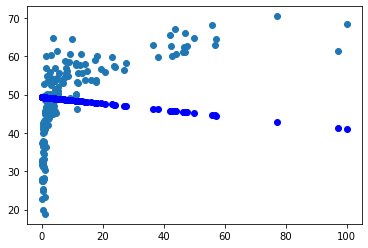

In [10]:
for col in df.columns:
    if col not in ["Year","Country"]:
            max_val=df[col].max()
            df[col]=df[col].apply(normalize)
    
    
df["PERFORMANCE"]=0.20*(100-df["HLY0"])+0.10*(100-df["HLY60"])+0.2*(100-df["IMR5"])+0.1*(100-df['IMR1'])+0.2*df["SCI"]+0.2*df["SHW"]
#print(df[df["PERFORMANCE"]>=60]["Country"])
df["root"]=df["CHE"].apply(root)

df.dropna(inplace=True)
X=np.array(df["CHE"]).reshape(-1,1) 
poly=sklearn.preprocessing.PolynomialFeatures(1)
X_poly=poly.fit_transform(X)

X_train,X_test=sklearn.model_selection.train_test_split(X_poly,test_size=0.01)
y_train,y_test=sklearn.model_selection.train_test_split(df["PERFORMANCE"],test_size=0.01)
model=sklearn.linear_model.LinearRegression().fit(X_train,y_train)

plt.figure()
plt.scatter(df["CHE"],df["PERFORMANCE"])
plt.scatter(X, model.predict(poly.fit_transform(X)),color='blue')

[4.50146038e+00 2.02563397e+04 2.02640934e+04] [[ 9.41154081e-02 -4.56976960e+03 -4.56328053e+03]
 [-4.56976960e+03  2.28279666e+08  2.27948063e+08]
 [-4.56328053e+03  2.27948063e+08  2.27627613e+08]]


Text(0, 0.5, 'Indice de performance')

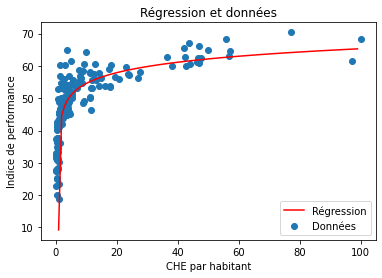

In [23]:
def func(x,a,b,c):
    return a*np.log(abs(b*x-c))
X=np.array(df["CHE"])
y=np.array(df["PERFORMANCE"])
popt, pcov = sp.optimize.curve_fit(func, X, y)

#plt.scatter(df["CHE"], func(df["CHE"], *popt), 'r-')
print(popt,pcov)
abscisse=range(1,100)

line1=plt.scatter(df["CHE"],df["PERFORMANCE"],label="Données")
line2=plt.plot(abscisse,func(abscisse,*popt),'r',label='Régression')
plt.legend()
plt.title("Régression et données")
plt.xlabel("CHE par habitant")
plt.ylabel("Indice de performance")

In [ ]:
fig=px.scatter_matrix(df,dimensions=["HLY0","HLY60","IMR1","IMR5","SCI","SHW","CHE","PERFORMANCE"])
fig.show()

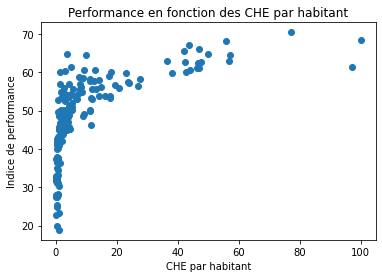

In [16]:
plt.figure()
plt.title("Performance en fonction des CHE par habitant") 
plt.xlabel("CHE par habitant")
plt.ylabel("Indice de performance")
plt.scatter(df["CHE"],df["PERFORMANCE"])

In [ ]:
import seaborn as sns
ax = sns.boxplot(data=df.drop("Year",axis=1),orient="h")

In [ ]:
#df=df.drop(["indice_composite","root"], axis=1)
#df.drop("Skilled",axis=1,inplace=True)

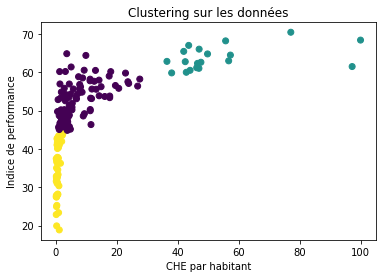

In [28]:
from sklearn.cluster import KMeans

new_df=df[["CHE","PERFORMANCE"]]

kmeans = KMeans(n_clusters=3,n_init=10,init='random').fit(new_df) #trying to find 4 clusters, 4 being a purely aritrairy number
centers=kmeans.cluster_centers_
kmeans.labels_
plt.title("Clustering sur les données")
plt.xlabel("CHE par habitant")
plt.ylabel("Indice de performance")
plt.scatter(new_df["CHE"], new_df["PERFORMANCE"],c=kmeans.labels_) 

In [30]:
kmeans.labels_

array([2, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 2, 1, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1, 2, 0,
       0, 0, 0, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0,
       1, 2, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0,
       1, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 1, 0, 2, 2,
       1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 1, 2, 1, 0, 0, 0, 0, 2, 2, 2])

In [41]:
low=[]
mid=[]
high=[]
for i in range(len(kmeans.labels_)):
    if i!=87 and i!=146:
        if kmeans.labels_[i]==0:
            mid.append(df["Country"][i])
        if kmeans.labels_[i]==1:
            high.append(df["Country"][i])
        if kmeans.labels_[i]==2:
            low.append(df["Country"][i])

In [47]:
high
mid
low

SyntaxError: invalid syntax (<ipython-input-47-c204ff826f4a>, line 1)

In [57]:
print(df[df["PERFORMANCE"]<=25]["Country"])

29     Central African Republic
30                         Chad
94                         Mali
110                     Nigeria
134                Sierra Leone
Name: Country, dtype: object
